In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from d2l import torch as d2l

# 残差网络(ResNet)
## 函数类
考虑网络架构对于最优函数的影响, 假设神经网络架构为 $\mathcal{F}$, 同时我们想要寻找的最优函数为 $f^*$, 并且 $f* \in \mathcal{F}$, 使用 $f_{\mathcal{F}}^*$ 表示利用神经网络架构 $\mathcal{F}$ 找到的最优函数, 那么可以利用如下公式找到对应的最优函数:
$$
f_{\mathcal{F}}^{*} := \underset{f}{\text{argmin}} \, L(\mathbf{X}, \mathbf{y}, f) \quad \text{subject to} \quad f \in \mathcal{F}.
$$
暗示如果我们想要找到更加优秀的网络架构从而得到更优的 $f^*$, 比如我们想要找到一个网络架构 $\mathcal{F}'$使得得到的 $f_{\mathcal{F}'}^*$ 更优, 此时应该保证 $\mathcal{F} \subseteq \mathcal{F}'$ (本质上就是更新过程中的最优值是否可以优于原来的最优值, 包含关系一定可以满足这一个要求), 非嵌套函数\嵌套函数的区别如下:
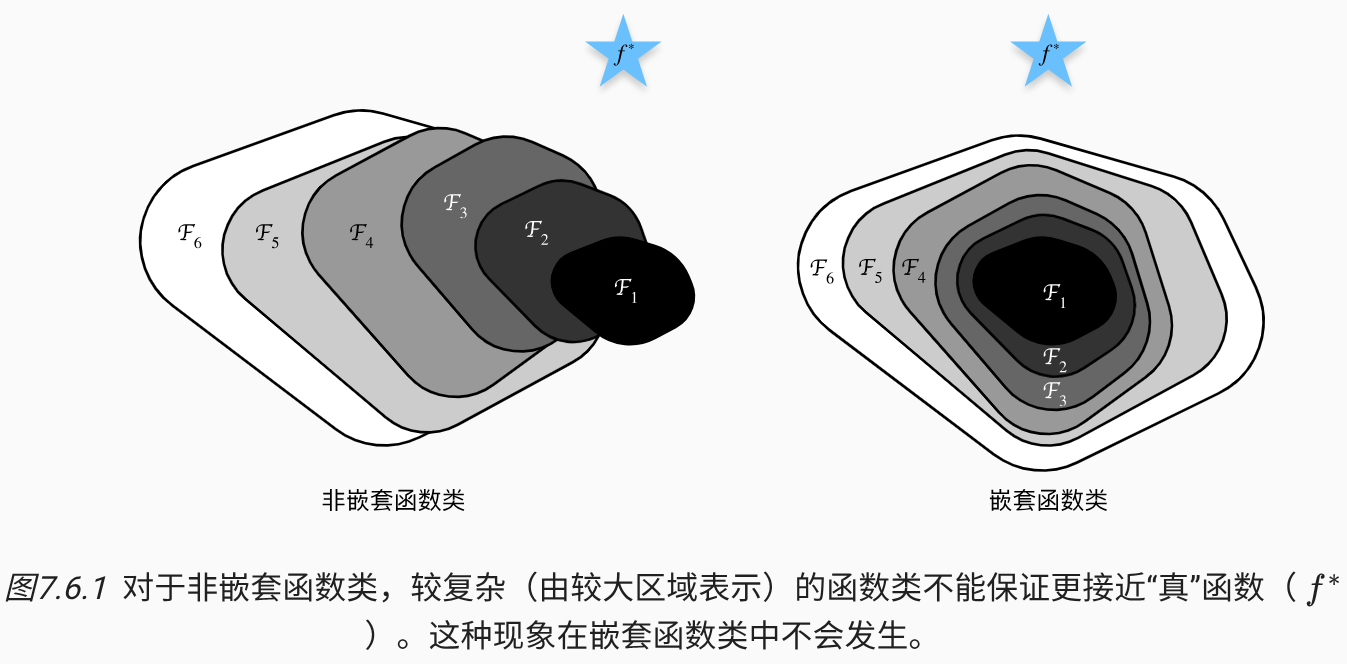

针对于这一个问题, 提出了残差网络(`ResNet`), 核心思想是: 在每一个附加层都应该更容易包含原始函数作为其元素之一

## 残差块
假设原始输入为 $x$, 同时希望学习出的理想映射为 $f(\mathbf{x})$, 对于传统的 `MLP`, 直接映射出 $f(\mathbf{x})$, 但是在残差块中需要拟合出残差映射 $f(\mathbf{x}) - x$, 残差应设在现实中往往更加容易优化, 如下是 `ResNet`基础架构中残差块, 在残差块中, 输入可以通过跨层数据线率更快传输:
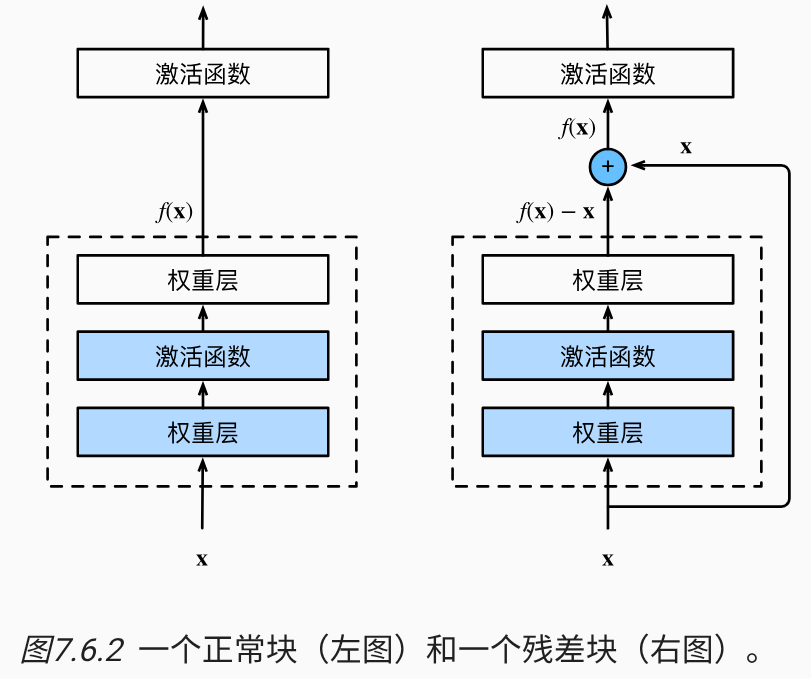
同时 `ResNet` 沿用了 `VGG` 完整的 $3 \times 3$ 卷积层涉及, 残差块中首先存在 2 个相同输出通道的 $3 \times 3$卷积层, 并且每一个卷积层后面接一个批量规范化层和 `ReLU` 激活函数, 之后通过跨层数据通路, 跳过这 2 个卷积运算, 把输入直接加在后面的 `ReLU` 激活函数前面, 网络结构如下:
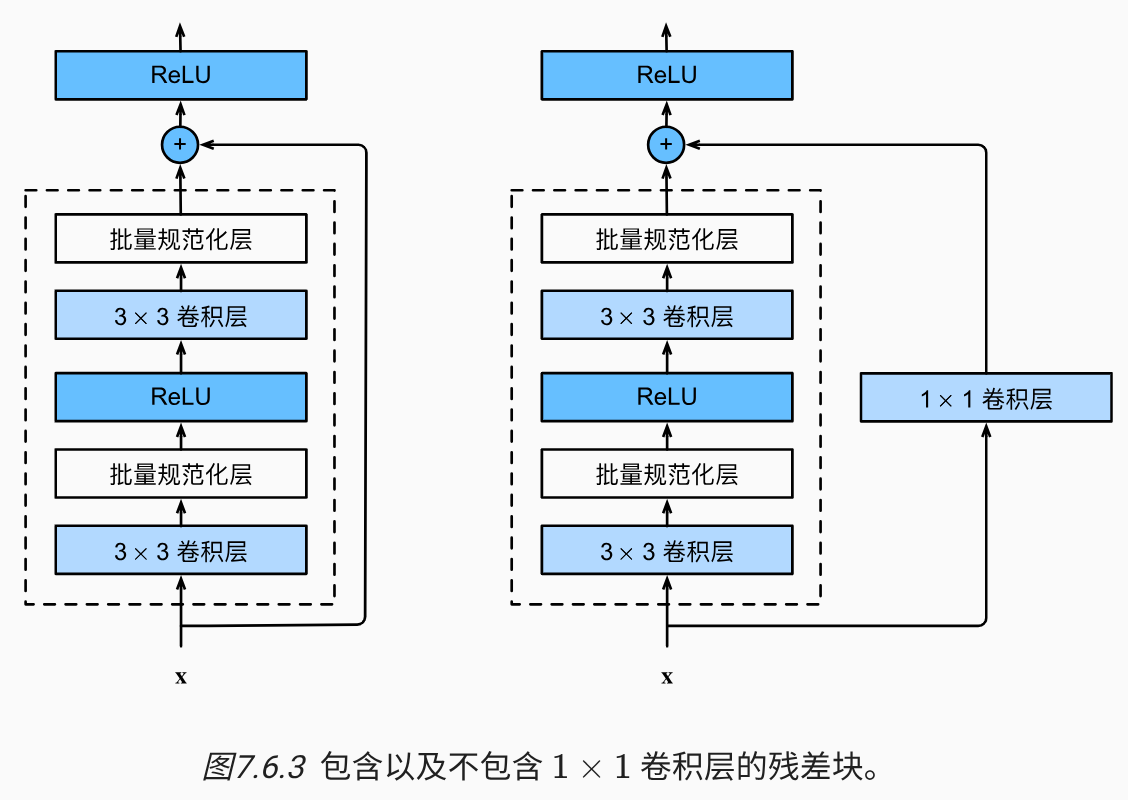

In [24]:
# 残差块
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, 
                use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                              kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                              kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, 
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [25]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

## ResNet 模型
`ResNet-18` (残差层*4 + 卷积层*1 + 全连接层*1) 网络结构如下:
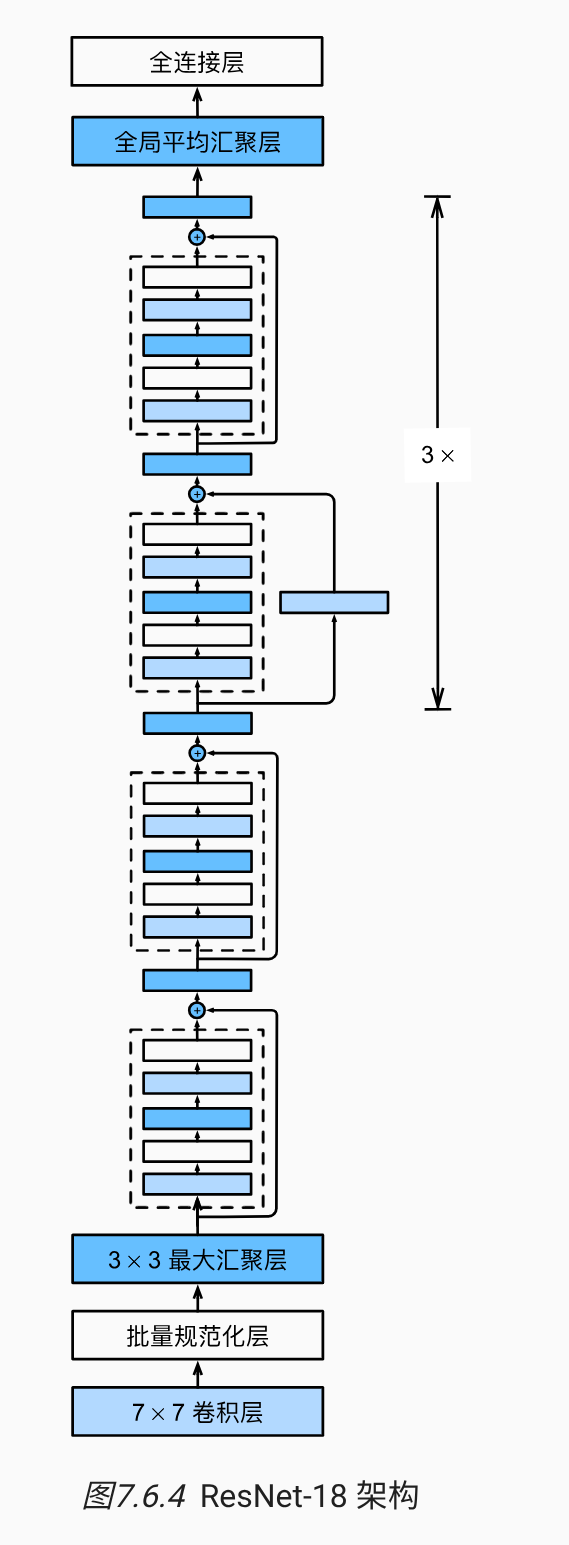

In [26]:
# ResNet 网络结构实现
# 残差块
def resnet_block(input_channels, num_channels, num_residuals, 
                first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, 
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk
# ResNet 网络层
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3))

In [27]:
# ResNet 网络结构
# 1. 卷积层:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, padding=3, stride=2),
                  nn.BatchNorm2d(64), nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# 2. 残差块层
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [28]:
# ResNet 模型结构
net = nn.Sequential(b1, b2, b3, b4, b5,
                   nn.AdaptiveAvgPool2d((1, 1)), # 表示聚集成一层
                   nn.Flatten(), nn.Linear(512, 10))

In [29]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, '\t output shape: \t', X.shape)

Sequential 	 output shape: 	 torch.Size([1, 64, 56, 56])
Sequential 	 output shape: 	 torch.Size([1, 64, 56, 56])
Sequential 	 output shape: 	 torch.Size([1, 128, 28, 28])
Sequential 	 output shape: 	 torch.Size([1, 256, 14, 14])
Sequential 	 output shape: 	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d 	 output shape: 	 torch.Size([1, 512, 1, 1])
Flatten 	 output shape: 	 torch.Size([1, 512])
Linear 	 output shape: 	 torch.Size([1, 10])


## 模型训练
> 网络太深了, 略过

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size, resize=224)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device)

## 思考
**Q1:** 为什么对于 $f(x) = x + g(x)$, 其中 $f(x)$ 比 $g(x)$ 更加容易学习到 ?
最终损失函数中使用 $f(x)$ 来更新参数, 此时 $\frac {\partial f(x)}{\partial x} = 1 + \frac {\partial g(x)}{\partial x}$, 此时 $f(x)$ 的梯度至少为 $1$, 使得梯度可以更加顺畅的反向传播 ; 同时 $g(x)$ 是残差信息, 更加容易学习

# DenseNet(稠密连接网络)
## 从 ResNet 到 DenseNet
对于任意函数可以展开为:
$$
f(x) = f(0) + f'(0)x + \frac{f''(0)}{2!}x^2 + \frac{f'''(0)}{3!}x^3 + \ldots
$$
同时 `ResNet` 把函数展开为: 
$$
f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x})
$$
`DenseNet` 把函数拓展为多个部分的信息(相当于把函数进行一系列的分解, 之后再进行连接):
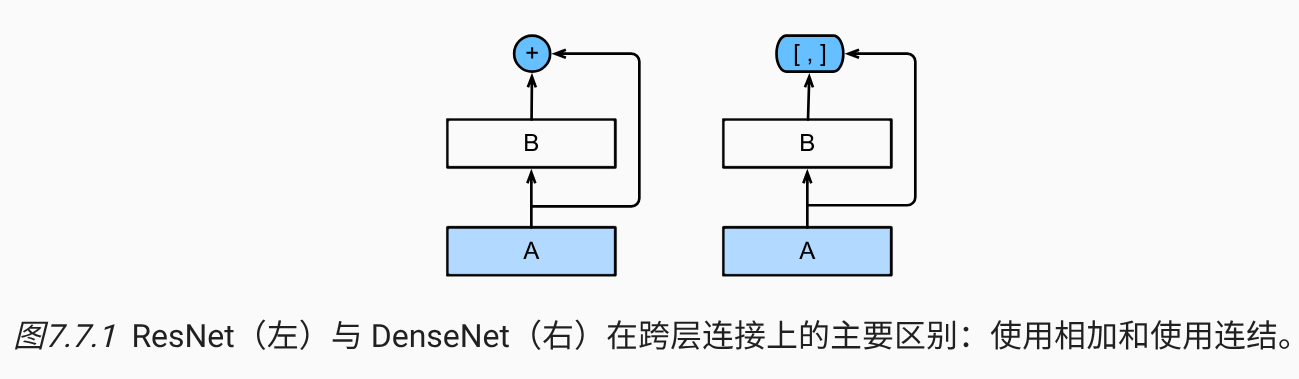
再应用越来越复杂的函数序列的时候, 执行从 $\mathbf{x}$ 到起展开式的映射:
$$
\mathbf{x} \to \left[ \mathbf{x}, f_1(\mathbf{x}), f_2\bigl([\mathbf{x}, f_1(\mathbf{x})]\bigr), f_3\bigl([\mathbf{x}, f_1(\mathbf{x}), f_2\bigl([\mathbf{x}, f_1(\mathbf{x})]\bigr)]\bigr), \ldots \right].
$$
之后把这些展开式结合到多层感知机上, 再一次减少特征数量, 此时只需要直接相连即可:
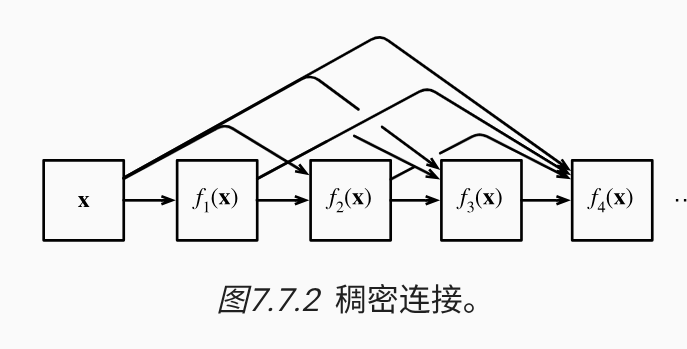
同时稠密网络有两个部分组成: 稠密块和过渡层

## 稠密块体
一个稠密块由多个卷积块组成, 每一个卷积块使用相同数量的输出通道, 再前向传播中, 将每一个卷积块的输入和输出再通道维度上连接起来

In [32]:
# 卷积块
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
    )

# 稠密块(可以记录更多信息?)
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        # 注意维度信息
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels*i + input_channels, num_channels
            ))
        self.net = nn.Sequential(*layer)
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 注意在特征维度上进行拼接, 其实是表示不同数据的特征
            X = torch.cat((X, Y), dim=1)
        return X

In [36]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape # 注意特征数增加, 注意区分维度和维度对应的长度 input_channels + num_convs * num_channels

torch.Size([4, 23, 8, 8])

## 过渡层
每一个稠密层都会带来通道数的增加(特征增加), 使用过渡层来控制模型的复杂度, 同时 $1 \times 1$ 的卷积层来减少通道数, 并且使用步幅为 2 的平均汇聚层减少高和宽, 从而降低模型复杂度

In [37]:
# 过渡层
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )

In [38]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## DenseNet 模型
DenseNet 首先使用和 ResNet 一样的单卷积层和最大聚集层, 之后使用 4 个稠密块

In [40]:
# 前面的卷积层
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [42]:
# 稠密块
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks =[]
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数(注意 DenseBlock 计算方式)
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [43]:
# 网络结构
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

## 模型训练

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device)